Start of n-step TD Methods on the Random Walk 2018-09-18 08:05:15.869150
[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]




  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:20<03:00, 20.01s/it]

 20%|████████████████▌                                                                  | 2/10 [00:40<02:40, 20.00s/it]

 30%|████████████████████████▉                                                          | 3/10 [01:01<02:22, 20.40s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [01:25<02:07, 21.26s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [01:52<01:52, 22.51s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:26<01:37, 24.33s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:12<01:22, 27.45s/it]

 80%|█████████████████████████

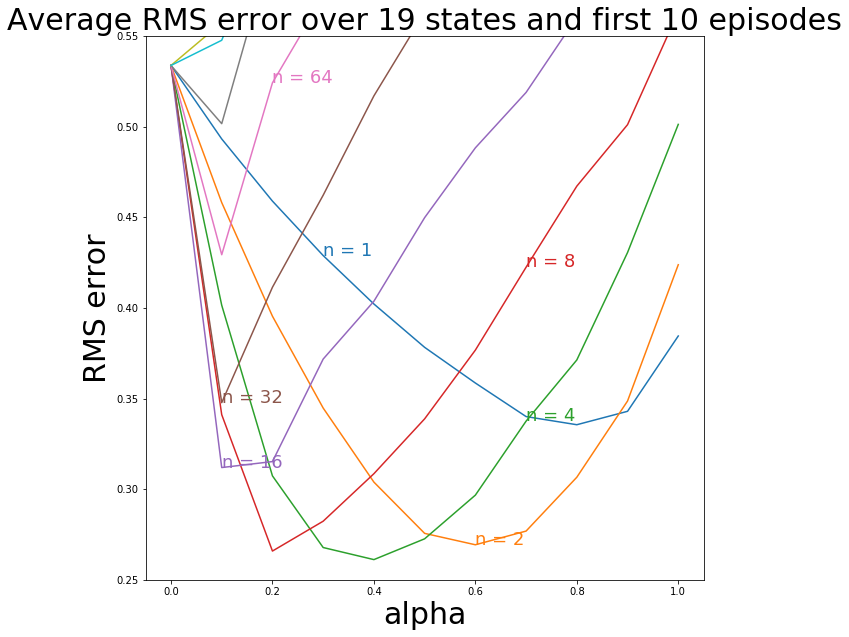


End of n-step TD Methods on the Random Walk 2018-09-18 08:11:22.616690
Running Time 0:06:06.747540


In [13]:
"""Example 7.1: n-step TD Methods on the Random Walk
Author : SeongJin Yoon
"""
import numpy as np
import random
import datetime as dt
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

REWARD = 0
STATE = 1
debug_mode = False
class Action():
    left = 0
    right = 1
    
    @staticmethod
    def to_str(action):
        assert action == Action.left or action == Action.right 
        strlist = ["left", "right"]
        return strlist[action]

class RandomWalk():
    def __init__(self, num_states):
        # self.state_list = ['LM', 'A', 'B', 'C', 'D', 'E', 'RM']
        ascii_uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        self.state_list = ['LM']
        for i in range(num_states):
            self.state_list.append(ascii_uppercase[i])
        self.state_list.append('RM')

        self.start_idx = (num_states + 2)//2
        self.start = self.state_list[self.start_idx]
        self.terminal = ['LM', 'RM']
        self.init_policy()
        self.init_true_value(num_states)
        
    def init_policy(self):
        self.policy = np.full((len(self.state_list),2), 0.5)
        
        # terminal state
        for state in self.terminal:
            state_idx = self.state_list.index(state)
            self.policy[state_idx, Action.left] = 0
            self.policy[state_idx, Action.right] = 0

    def init_true_value(self, num_states):
        half = (num_states + 2)//2
        self.true_value = np.arange(-half, half+1, 1) / half
        print(self.true_value)
        self.true_value[0] = self.true_value[-1] = 0.0
            
    def init_value(self):
        V = np.full(len(self.state_list), 0.0)
        for state in self.terminal:
            state_idx = self.state_list.index(state)
            V[state_idx] = 0.0
    
        return V
    
    def get_reward(self, state_idx):
        state = self.state_list[state_idx]
        if state == 'LM':
            return -1
        if state == 'RM':
            return 1
        return 0
    
    def is_terminal(self, state_idx):
        state = self.state_list[state_idx]
        if state in self.terminal:
            return True
        return False
    
    def get_action_idx(self, state_idx):
        best_idx = np.argmax(self.policy[state_idx])
        best = self.policy[state_idx, best_idx]
        max_list = np.argwhere(self.policy[state_idx] == best)
        max_list = max_list.flatten()
        action_idx = max_list[random.randint(0,len(max_list)-1)]
        return action_idx
        
    def do_action(self, state_idx, action_idx):
        
        if self.is_terminal(state_idx):
            return state_idx, self.reward()
            
        next_state_idx = 0
        if action_idx == Action.left:
            next_state_idx = state_idx - 1
        elif action_idx == Action.right:
            next_state_idx = state_idx + 1

        return next_state_idx, self.get_reward(next_state_idx)
     
    def n_step_TD(self, n, V, alpha):
        discount = 1
        state_idx = self.start_idx
        
        trajectory = []
        trajectory.append([0, state_idx])
        t = 0
        T = float('inf')
        tau = -1
        while tau != (T-1):
            # Store reward and state for each time            
            if t < T:
                t += 1
                action_idx = self.get_action_idx(state_idx)
                next_state_idx, reward = self.do_action(state_idx, action_idx)
                trajectory.append([reward, next_state_idx])
                if self.is_terminal(next_state_idx): T = t
                
                if debug_mode :
                    print("t %d, state %s, action %s, next state %s, reward %f" % 
                          (t,
                           self.state_list[state_idx], 
                           Action.to_str(action_idx), 
                           self.state_list[next_state_idx], reward ))
                
            # Calculate n-step Return and state value
            tau = t - n
            if tau >= 0:
                G = 0
                for i in range(tau+1, min(tau+n, T)+1):
                    reward, _ = trajectory[i]
                    G += pow(discount, i-tau-1)*reward
                
                if (tau+n) < T :
                    _, state_idx = trajectory[tau+n]
                    G += pow(discount, n)*V[state_idx]
                
                _, state_idx = trajectory[tau]
                if self.is_terminal(state_idx) is False:
                    V[state_idx] += alpha*(G - V[state_idx])
                    
                if debug_mode :
                    print("tau %d, state %s, alpha %f, G %f, V %f" % 
                          (tau, self.state_list[state_idx], alpha, G, V[state_idx]))

            state_idx = next_state_idx
            
    def n_step_TD_original(self, n, V, alpha):
        discount = 1
        state_idx = self.start_idx
        
        trajectory = []
        trajectory.append([0, state_idx])
        t = 0
        T = 100000 # inifity
        tau = -1
        while tau != (T-1):
            # Store reward and state for each time            
            if t < T:
                action_idx = self.get_action_idx(state_idx)
                next_state_idx, reward = self.do_action(state_idx, action_idx)
                trajectory.append([reward, next_state_idx])
                if self.is_terminal(next_state_idx): T = t+1
                
                if debug_mode :
                    print("t %d, state %s, action %s, next state %s, reward %f" % 
                          (t,
                           self.state_list[state_idx], 
                           Action.to_str(action_idx), 
                           self.state_list[next_state_idx], reward ))
                
            # Calculate n-step Return and state value
            tau = t - n + 1
            if tau >= 0:
                G = 0
                for i in range(tau+1, min(tau+n, T)+1):
                    reward, _ = trajectory[i]
                    G += pow(discount, i-tau-1)*reward
                
                if (tau+n) < T :
                    _, state_idx = trajectory[tau+n]
                    G += pow(discount, n)*V[state_idx]
                
                _, state_idx = trajectory[tau]
                V[state_idx] += alpha*(G - V[state_idx])
                if debug_mode :
                    print("tau %d, state %s, alpha %f, G %f, V %f" % 
                          (tau, self.state_list[state_idx], alpha, G, V[state_idx]))

            state_idx = next_state_idx
            t += 1
            
    def calc_rms_error(self, V):
        
        error = (self.true_value - V)[1:len(V)]
        rms_error =  math.sqrt(np.mean(error**2))
            
        return rms_error
    
    def draw_rms_plot(self):
        self.plot = Plot(nrows=1, ncols=1, figsize=(10,10))
        labels = ['alpha', 'RMS error', 
                    'Average RMS error over 19 states and first 10 episodes']
        ylim = [0.25, 0.55]
        ax = self.plot.draw_mline_begin(labels, ylim)   
        
        
        num_runs = 100
        num_episode = 10
        alpha_list = np.arange(0.0, 1.1, 0.1)
        num_alphas = len(alpha_list)
        
        
        for log_n_step in tqdm(range(0,10)):
            n_step = pow(2, log_n_step)
            avg_rms_error = np.zeros(num_alphas)
            for alpha_idx, alpha in enumerate(alpha_list):
                for run in range(0, num_runs):
                    V = self.init_value()
                    for episode_idx in range(num_episode):
                        self.n_step_TD_original(n_step, V, alpha)
                        rms_error = self.calc_rms_error(V)
                        avg_rms_error[alpha_idx] += rms_error
                        # print(V)
            avg_rms_error /= num_runs*num_episode
            label = "n = %d" % (n_step)
            linestyle = 'solid' # 'dashdot'
            self.plot.draw_mline(ax, alpha_list, avg_rms_error, label, linestyle)
        
        self.plot.draw_mline_end()
        self.plot.show()

class Plot():
    def __init__(self, nrows, ncols, figsize):
        self.fig_idx = 0
        self.len_axes = nrows*ncols
        
        _, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        if self.len_axes != 1:
            self.axes = self.axes.flatten()

    def get_axes(self, idx):
        if self.len_axes != 1: 
            ax = self.axes[self.fig_idx]
        else:
            ax = self.axes
        return ax
    
    def draw_mline_begin(self, labels, ylim):       
        ax = self.get_axes(self.fig_idx)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        ax.set_ylim(ylim)
        self.ylim = ylim
        
        return ax
        
    def draw_mline(self, ax, pos, data, label, linestyle='solid'):
        lines = ax.plot(pos, data, label=label, linestyle=linestyle)
        
        pivot_idx = random.randint(0, (len(data)*2)//3)
        x_pos = pos[pivot_idx]
        y_pos = data[pivot_idx]
        if self.ylim[0] <= y_pos <= self.ylim[1] :
            ax.text(x_pos, y_pos, label, color = lines[0].get_color(), size=18)

    def draw_mline_end(self):       
        self.fig_idx += 1

    def draw_bar(self, pos, data, labels):
        ax = self.get_axes(self.fig_idx)
        ax.bar(pos, data)
        
        ax.set_xlabel(labels[0], fontsize=30)
        ax.set_ylabel(labels[1], fontsize=30)
        ax.set_title(labels[2], fontsize=30)
        self.fig_idx += 1
        
    def show(self):
        plt.show()

if __name__ == "__main__":
    begin_time = dt.datetime.now()
    print("Start of n-step TD Methods on the Random Walk", begin_time)
    num_states = 19
    randomwalk = RandomWalk(num_states)
    randomwalk.draw_rms_plot()
    
    end_time = dt.datetime.now()
    print()
    print("End of n-step TD Methods on the Random Walk", end_time)
    print("Running Time", end_time - begin_time)